# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

2023-06-02 20:18:00.585056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the model class and some custom functions
import sys
sys.path.append('../')
from models import get_autoencoder_model, get_dec_model, compute_p, compute_delta
from clustering_metrics import evaluate_model
from draw_embeddings import draw_embeddings, draw_matched_labels, compare_reconstructed_images_MNIST

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load and prepare the MNIST data set

In [4]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test  = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct and pretrain the autoencoder

In [5]:
IMG_DIM    = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)

# EPOCHS        = 300 # Recommended number of epochs
EPOCHS        = 5 # Just to test that it works
BATCH_SIZE    = 128
LEARNING_RATE = 1
MOMENTUM      = 0.9

model_ae = get_autoencoder_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

2023-06-02 20:08:54.992365: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model_ae.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
                 loss="mse")

model_ae.fit(x_train, x_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             verbose=1,
            )

model_ae.save_weights("model_weights/dec/pretrained/ae")
# model_ae.load_weights("model_weights/dec/pretrained/ae")

Epoch 1/5
469/469 [==============================] - 31s 65ms/step - loss: 0.0787
Epoch 2/5
469/469 [==============================] - 32s 68ms/step - loss: 0.0560
Epoch 3/5
469/469 [==============================] - 32s 68ms/step - loss: 0.0393
Epoch 4/5
469/469 [==============================] - 32s 69ms/step - loss: 0.0294
Epoch 5/5
469/469 [==============================] - 31s 66ms/step - loss: 0.0257


## Show the resulting embeddings

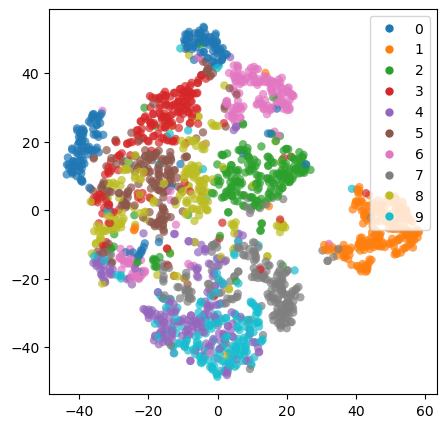

In [7]:
if LATENT_DIM == 2:
    z_test = model_ae.encode(x_test)
    draw_embeddings(z_test, y_test)
else:
    z_test = model_ae.encode(x_test)
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000])

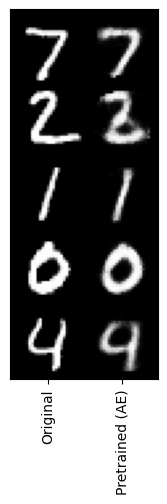

In [8]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_ae.encoder, model_ae.decoder, ("Original", "Pretrained (AE)"))

# Fine-tune the model (K-Means)

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [9]:
# model_ae.load_weights("model_weights/dec/pretrained/ae")

Construct the VaDE model:

In [10]:
N_CLUSTERS = 10

# EPOCHS          = 100 # Recommended number of epochs
EPOCHS          = 5 # Just to test that it works
BATCH_SIZE      = 128
LEARNING_RATE   = 0.01
MOMENTUM        = 0.9
SCHEDULE        = 10
DELTA_THRESHOLD = 0.001

model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)

## Initialize the parameters

Initialize the model parameters from a K-means:

In [11]:
z_train = model_dec.encode(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [12]:
p      = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

In [13]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_dec.encode(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

{'Acc': 0.5097,
 'ARI': 0.3184837048109483,
 'AMI': 0.4627420443646938,
 'Sil': 0.18783264}

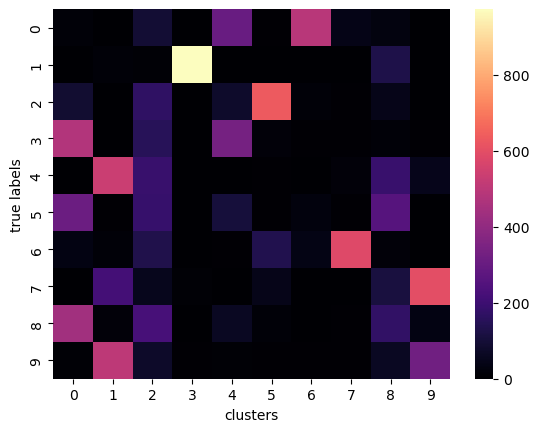

In [14]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)

## Train the model

Train the model:

In [15]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new  = q.numpy().argmax(1)
        delta  = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

In [16]:
model_dec.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM))

model_dec.fit(x          = x_train,
              y          = p,
              epochs     = EPOCHS,
              batch_size = BATCH_SIZE,
              callbacks  = callback,
              verbose    = 1,
             )

model_dec.save_weights("model_weights/dec/finetuned/dec_kmeans")
# model_dec.load_weights("model_weights/dec/finetuned/dec_kmeans")

Epoch 1/5
469/469 [==============================] - 19s 39ms/step - loss: 5.5525
Epoch 2/5
469/469 [==============================] - 18s 38ms/step - loss: 3.4594
Epoch 3/5
469/469 [==============================] - 18s 38ms/step - loss: 2.6585
Epoch 4/5
469/469 [==============================] - 18s 38ms/step - loss: 2.2728
Epoch 5/5
469/469 [==============================] - 18s 38ms/step - loss: 2.0329


## Show the resulting embeddings

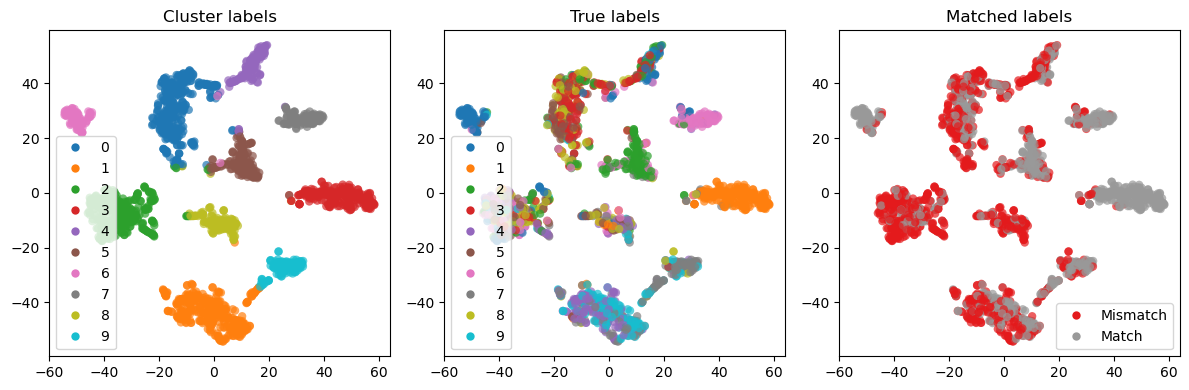

In [17]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

## Evaluate the model

{'Acc': 0.5132,
 'ARI': 0.3261344583581602,
 'AMI': 0.4861816402811892,
 'Sil': 0.8453453}

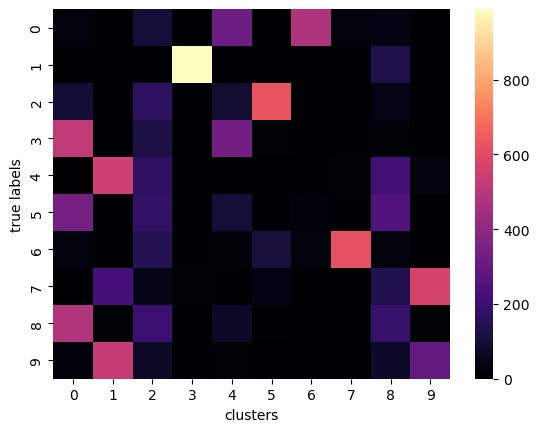

In [18]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [19]:
model_ae.load_weights("model_weights/dec/pretrained/ae")

In [20]:
N_CLUSTERS = 10

# EPOCHS          = 100 # Recommended number of epochs
EPOCHS          = 5 # Just to test that it works
BATCH_SIZE      = 128
LEARNING_RATE   = 0.01
MOMENTUM        = 0.9
SCHEDULE        = 10
DELTA_THRESHOLD = 0.001

model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)

## Initialize the parameters

In [21]:
z_train = model_dec.encode(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=10)
gmm.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [22]:
p      = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

In [23]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_dec.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=gmm.means_)

{'Acc': 0.4859,
 'ARI': 0.31498678622166204,
 'AMI': 0.45208141202391694,
 'Sil': 0.18000568}

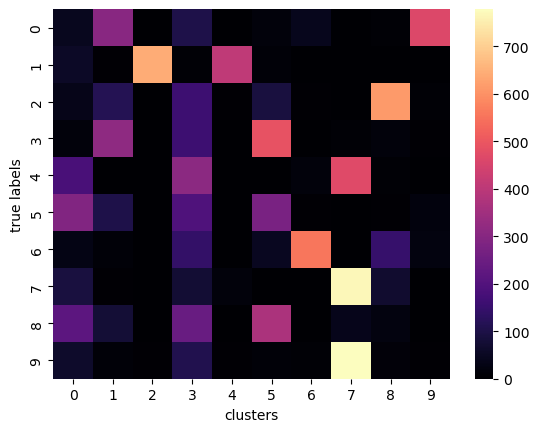

In [24]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)

## Train the model

In [25]:
model_dec.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM))

model_dec.fit(x          = x_train,
              y          = p,
              epochs     = EPOCHS,
              batch_size = BATCH_SIZE,
              callbacks  = callback,
              verbose    = 1,
             )

model_dec.save_weights("model_weights/dec/finetuned/dec_gmm")
# model_dec.load_weights("model_weights/dec/finetuned/dec_gmm")

Epoch 1/5
469/469 [==============================] - 21s 44ms/step - loss: 5.3126
Epoch 2/5
469/469 [==============================] - 18s 39ms/step - loss: 3.4120
Epoch 3/5
469/469 [==============================] - 19s 40ms/step - loss: 2.6587
Epoch 4/5
469/469 [==============================] - 17s 37ms/step - loss: 2.2931
Epoch 5/5
469/469 [==============================] - 18s 38ms/step - loss: 2.0348


## Show the resulting embeddings

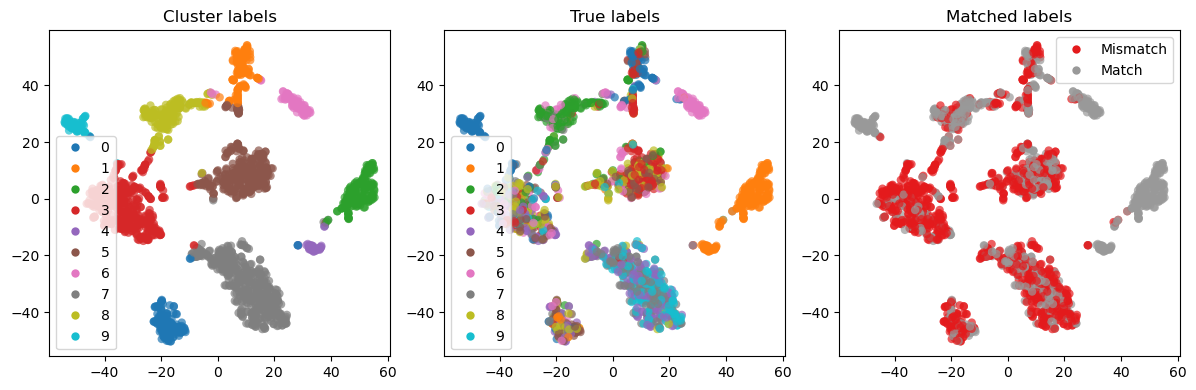

In [26]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

## Evaluate the model

{'Acc': 0.4948,
 'ARI': 0.3449207816631647,
 'AMI': 0.47330797255031437,
 'Sil': 0.8365374}

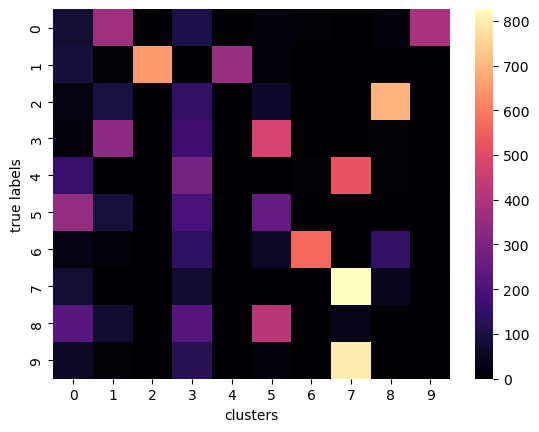

In [27]:
evaluate_model(x_test, y_test, model_dec.classify, model_dec.encode)